In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import altair
import vega_datasets
import sklearn
import bokeh
import datashader
import holoviews
import wordcloud
import spacy
import datetime

### Import data

In [2]:
# Food expenditures data from ERS (Economic Research Service, USDA)
#########foodexp = pd.read_csv('faps_fahitem_puf.csv')
#########with open(, 'rb') as f:
    ###########contents = f.read()
# NOTE - I need to find the documentation for this, not sure what dates I am looking at?

In [3]:
# Monthly expenditures data, ERS (USDA) Updated Feb 25, 2020
#Note, 'constant dollar' refers to 1988 = 100
monthly_sales=pd.read_csv('./data/monthly_sales_cleaned.csv')
monthly_sales.head()

,Year,Month,FAH_nominal_wtax_wtips_million,FAFH_nominal_wtax_wtips_million,Total_nominal_food_sales_million,FAH_constdollar_million,FAFH_constdollar_million,Total_constant_dollar_food_sales_million
0,2019.0,December,"74,901.67","73,337.91","148,239.58","36,125.06","31,012.62","67,423.64"
1,2019.0,November,"69,798.19","69,585.45","139,383.64","33,666.99","29,510.12","63,482.68"
2,2019.0,October,"67,301.77","71,609.53","138,911.30","32,380.60","30,417.63","63,227.35"
3,2019.0,September,"64,101.42","69,391.72","133,493.14","30,942.60","29,531.69","60,922.88"
4,2019.0,August,"69,333.52","75,675.25","145,008.77","33,522.32","32,289.19","66,314.81"


In [4]:
# Census data
# https://www.census.gov/econ/currentdata/dbsearch?program=MARTS&startYear=1992&endYear=2020&categories%5B%5D=445&categories%5B%5D=4451&categories%5B%5D=446&categories%5B%5D=722&dataType=SM&geoLevel=US&adjusted=1&notAdjusted=1&submit=GET+DATA&releaseScheduleId=
census = pd.read_csv('./data/census_data_all.csv')
grocery = pd.read_csv('./data/census_grocery_only.csv')
census_dates= pd.read_csv('./data/census_per_index_dates.csv')
foodservice = pd.read_csv('./data/census_foodservice_only.csv')

### EDA: census data


This data gives "Advance monthly sales for retail and food services", one data point per month for all years between Jan 1992 and March 2020. 

- per_idx is the period index or date at which the data was collected. These correspond to actual date values.
- dt_idx describes the data type: 1 = Monthly sales in millions of US dollars. 2 = Monthly sales % change.
- et_idx describes error types: 1 = CV of sales, monthly. 2 = SE of sales, monthly % change.
- is_adj refers to whether or not the data was (1) or was not (0) seasonally adjusted.
- val = monthly sales value in millions of US dollars from (in this case) grocery stores.

All data was taken over the entire US as a whole.
Data source: US Census

In [5]:
census.shape

(45962, 7)

In [6]:
census.describe()

,per_idx,cat_idx,dt_idx,et_idx,geo_idx,is_adj,val
count,45962.000000,45962.000000,45962.000000,45962.000000,45962.0,45962.000000,45962.000000
mean,191.761499,11.265002,0.927505,0.572038,1.0,0.500000,27901.286963
std,91.300152,5.991364,0.827636,0.791317,0.0,0.500005,79278.020124
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,-62.400000
25%,125.000000,6.000000,0.000000,0.000000,1.0,0.000000,0.300000
50%,197.000000,11.000000,1.000000,0.000000,1.0,0.500000,1.500000
75%,269.000000,16.000000,2.000000,1.000000,1.0,1.000000,9783.750000
max,339.000000,21.000000,2.000000,2.000000,1.0,1.000000,591380.000000


#### Joining correct per_name column

In [7]:
census = census.merge(census_dates, how = 'left', on = 'per_idx')
census['per_name']=pd.to_datetime(census['per_name'], format='%m/%d/%Y')
census.head()


,per_idx,cat_idx,dt_idx,et_idx,geo_idx,is_adj,val,per_name
0,1,5,1,0,1,0,130683.0,1992-01-01
1,1,5,1,0,1,1,146925.0,1992-01-01
2,1,6,1,0,1,0,29811.0,1992-01-01
3,1,6,1,0,1,1,33478.0,1992-01-01
4,1,7,1,0,1,0,26788.0,1992-01-01


#### Filtering data to include only food-related columns 

In [8]:
# Filter out only the food-related cat_idx values we care about: 11, 12, 13, 21
census = census[census.cat_idx.isin([11, 12, 13, 21])]

# Filters:

# Only dollar data, separated by adjusted/unadjusted
census_unadj = census[(census['is_adj'] < 1) & (census['dt_idx'] == 1)] # this is $ data
census_adj = census[(census['is_adj'] == 1) & (census['dt_idx'] == 1)] # this is $ data

# Only percentage data, separated by adjusted/unadjusted
#census_unadj_pct = census[(census['is_adj'] < 1) & (census['dt_idx'] == 2)] # this is % data
#census_adj_pct = census[(census['is_adj'] == 1) & (census['dt_idx'] == 2)] # this is % data



#### Reassigning the cat_idx codes to meanings

In [ ]:
# TO DO

In [ ]:
# ALSO check that the filter worked, for some reason chart below is not showing correct nums

#### Raw data plots (adjusted)

[Text(0, 0.5, 'Total U.S. Grocery Sales, Million $'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Total Adjusted U.S. Grocery Sales')]

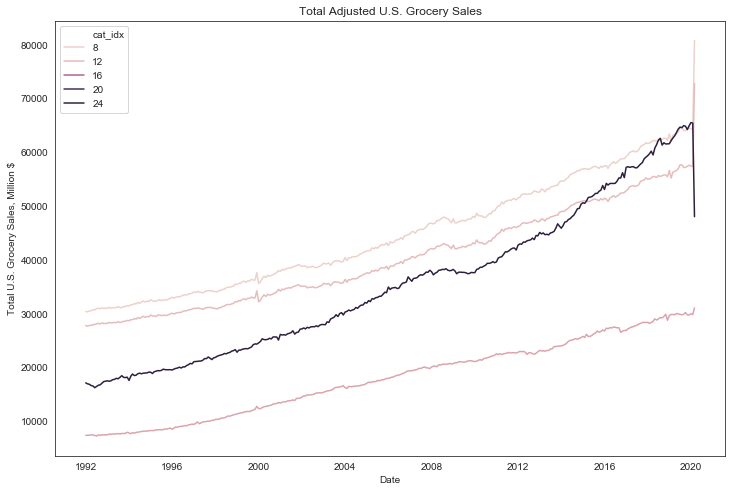

In [9]:
plotsize=(12,8)
sns.set_style("white")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="per_name", y="val", hue='cat_idx',data=census_adj)
#ax2 = plt.twinx()
#sns.lineplot(ax=ax2, x = 'per_name', y = 'val', hue='cat_idx', color= 'b', data= census_unadj)

ax.set(xlabel='Date', ylabel='Total U.S. Grocery Sales, Million $', title='Total Adjusted U.S. Grocery Sales')
#ax2.set(ylabel = 'Total U.S. Grocery Sales, Million $')
#ax.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))
#ax2.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))

In [ ]:

####### Grocery dataset

grocery=grocery.merge(census_dates, how='left', on='per_idx')
# Be sure per_name is a date datatype
grocery['per_name']=pd.to_datetime(grocery['per_name'], format='%m/%d/%Y')


######### Foodservice dataset

foodservice=foodservice.merge(census_dates, how='left', on='per_idx')
# Be sure per_name is a date datatype
foodservice['per_name']=pd.to_datetime(foodservice['per_name'], format='%m/%d/%Y')

Basic view of the raw data:

In [ ]:
# Filter out only the unadjusted raw data
grocery_unadj = grocery[(grocery['is_adj'] < 1) & (grocery['dt_idx'] == 1)]
grocery_unadj.head()


In [ ]:
plotsize=(12,8)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="per_name", y="val", data=grocery_unadj)
ax.set(xlabel='Date', ylabel='Total U.S. Grocery Sales, Million $', title='Total Unadjusted U.S. Grocery Sales, Jan 1992 - Mar 2020')

In [ ]:
# Filter out only the adjusted raw data
grocery_adj = grocery[(grocery['is_adj'] == 1) & (grocery['dt_idx'] == 1)]
#repeat above plot
plotsize=(12,8)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="per_name", y="val", data=grocery_adj)
ax.set(xlabel='Date', ylabel='Total U.S. Grocery Sales, Million $', title='Total Seasonally-Adjusted U.S. Grocery Sales, Jan 1992 - Mar 2020')

It's immediately clear that there is a huge spike recently, due to the COVID-19 pandemic. 

In [ ]:
# Unnecessary predecessor plot to the below

#plotsize=(12,8)
#fig, ax = plt.subplots(figsize=plotsize)
#sns.lineplot(ax=ax, x="per_name", y="val", data=grocery_adj)
#ax.set(xlabel='Date', ylabel='Total U.S. Grocery Sales, Million $', title='Total Seasonally-Adjusted U.S. Grocery Sales,Past 5 years')
#ax.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))

Now let's look at how this compares to the % change:

In [ ]:
grocery_adj_pct = grocery[(grocery['is_adj'] == 1) & (grocery['dt_idx'] == 2)]
grocery_adj_raw = grocery[(grocery['is_adj'] == 1) & (grocery['dt_idx']==1)]

plotsize=(12,8)
sns.set_style("white")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="per_name", y="val", color = 'r',data=grocery_adj_pct)
ax2 = plt.twinx()
sns.lineplot(ax=ax2, x = 'per_name', y = 'val', color= 'b', data= grocery_adj_raw)

ax.set(xlabel='Date', ylabel='Percent change in sales', title='Total Seasonally-Adjusted U.S. Grocery Sales, Jan 1992 - Mar 2020')
ax2.set(ylabel = 'Total U.S. Grocery Sales, Million $')

In [ ]:
plotsize=(12,8)
sns.set_style("white")
fig, ax = plt.subplots(figsize=plotsize)
sns.lineplot(ax=ax, x="per_name", y="val", color = 'r',data=grocery_adj_pct)
ax2 = plt.twinx()
sns.lineplot(ax=ax2, x = 'per_name', y = 'val', color= 'b', data= grocery_adj_raw)

ax.set(xlabel='Date', ylabel='Percent change in sales', title='Total Seasonally-Adjusted U.S. Grocery Sales, Past 5 years')
ax2.set(ylabel = 'Total U.S. Grocery Sales, Million $')
ax.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))
ax2.set(xlim=(datetime.date(2015,1,1), datetime.date(2020,4,1)))

### EDA: foodservice data

### EDA: monthly_sales

In [ ]:
monthly_sales.shape
#There are 281 rows and 8 columns

In [ ]:
monthly_sales.dtypes.value_counts()
monthly_sales.dropna()

In [ ]:
#Change dtypes from 'object' to float for other columns besides month

numcols=["FAH_nominal_wtax_wtips_million", 
               "FAFH_nominal_wtax_wtips_million", 
               "Total_nominal_food_sales_million", 
               "FAH_constdollar_million", 
               "FAFH_constdollar_million", 
               "Total_constant_dollar_food_sales_million"]

# Remove commas
monthly_sales[numcols] = monthly_sales[numcols].replace({',': ''}, regex=True)

#Convert strings without commas into numeric values
monthly_sales[monthly_sales.columns[2:]] = monthly_sales[monthly_sales.columns[2:]].apply(pd.to_numeric, downcast='float')
monthly_sales.dtypes.value_counts()

In [ ]:
monthly_sales.describe()

The data spans 1997 to December 2019. 

FAH = "Food At Home"
FAFH = "Food Away From Home"

Does not includ schools/institutions. Data is in millions of US dollars. Values are total monthly sales.